# 4.03: Data Preparation, EDA and Cleaning
---

In [199]:
import pandas as pd
from pandas_profiling import ProfileReport
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import string
import re
import feather
import csv
import os
import collections
from datetime import datetime
from pickletools import pickle
from bs4 import BeautifulSoup
from easymoney.money import EasyPeasy
% matplotlib inline

In [198]:
path = '../../../Large Datasets/capstone/feather/'
rep_path = '../../../Large Datasets/capstone/QJPS_6026_supp/'
cap_path = '../../../Large Datasets/capstone/'

In [3]:
files = os.listdir(path)

In [4]:
files = files[1:]

In [5]:
files

['1984_labeled_processed_race.feather',
 '1988_labeled_processed_race.feather',
 '1992_labeled_processed_race.feather',
 '1996_labeled_processed_race.feather',
 '2000_labeled_processed_race.feather',
 '2004_labeled_processed_race.feather',
 'anes_timeseries_2016.feather',
 'anes_timeseries_2016_voteval.feather',
 'anes_timeseries_cdf.feather',
 'annen061229.feather',
 'annen2004_processed.feather',
 'avgincome_orig.feather',
 'cces_cumul_0616_rds.feather',
 'cumulative_2006_2016_dta.feather',
 'fips.icpsr.cbs.naes.feather',
 'region_dummies.feather',
 'region_dummies_84.feather',
 'region_indic_annen2000.feather']

---

From Gelman, et al. (2005):

> Key methods used in this research are:
* (1) plots of repeated cross-sectional analyses,
* (2) varying-intercept, varying-slope multilevel models, and
* (3) a graph that simultaneously shows within-group and between-group patterns in a multilevel model.
> 
> These statistical tools help us understand patterns of variation within and between states in a way that would not be possible from classical regressions or by looking at tables of coefficient estimates.

> Comparing to previous studies of income and voting, our key contribution is to study patterns both within and between states, with both individual income and state-level income as predictors, using survey data on individuals and election and Census data for states and counties. The pattern that richer states support the Democrats is not a simple aggregation of rich voters supporting the Democrats. This can be viewed either as a debunking of the journalistic image of rich “latte” Democrats and poor “Nascar” Republicans—or as support for the journalistic images of political and cultural differences between red and blue states—differences which are not explained by differences in individuals’ incomes. We find that income matters more in “red America” than in “blue America.” In poor states, rich people are much more likely than poor people to vote for the Republican presidential candidate, but in rich states (such as Connecticut), income has almost no correlation with vote preference. The United States has red and blue voters, and red and blue states, but income cuts across them in different ways (a point noted by Alford (1963) in his study of social class and voting by region of the U.S.). As we shall see in Sections 2–4, the statistical technique of multilevel modeling allows us to understand the relation between income and vote among individuals, counties, and states.



> ### 2.  Studying the relation between income and vote preferences
>
> Survey data show a small but persistent correlation between income and support for the Republican party, but at the aggregate level, it is the Democrats who do better in the richer states. Our strategy to understand these patterns is to study the relation between income and voting in four ways:
>
> * Aggregate, by state: to what extent do richer states favor the Democrats?
> * Nationally, at the level of the individual voter: to what extent do richer voters support the Republicans?
> * Individual voters within states: to what extent do richer voters support the Republicans, within any given state? In other words, how much does context matter?
> * Counties within states: to what extent do richer counties favor the Democrats, within any given state?
>
> Patterns at these four levels have much different political interpretations from those supposed by confused political commentators. Most notably, the support for the Democrats in the richer states had led observers to view the typical Democrat as an upper-middle-class resident of a coastal metropolitan area, and the typical Republican as lower-middle-class and rural (see Brooks, 2001). That these claims have been overstated (see Frank, 2004, and Issenberg, 2004) does not seem to lessen their appeal. A multilevel strategy in understanding voting behavior is useful because we are interested in election outcomes as well as individual decisions. Elections are not simple cumulations of voter decisions (because of institutional features such as electoral rules and geographic boundaries, and the political decisions of parties and candidates), and so aggregate analysis should not be dis-carded simply by citing the ecological fallacy problem (Wright, 1989). Trends of economic voting at multiple levels of analysis may or may not be similar, and their causes may or may not besimilar.
>
>As in Wright (1989, p. 390), we consider the variation at eachlevel of analysis. Income varies far more within states than average income does between states. Consequently, it is the within-state rather than the between-state effect of income that dominates the national patterns. In particular, a positive correlation of income and Republican voting within states, plus a negative correlation between states, combine to form a positive correlation among all voters. We have both individual and aggregate data on income and votes. Thus, the statistical analysis is relatively straightforward, without the well-known problems that can arise when only aggregate data are available (Robinson, 1950, Kramer, 1983).
>
> * For individual vote preferences, we use the National Election Study (NES) polls taken during the month before each election.
> * For aggregate patterns, we use presidential election returns and Bureau of Economic Affairs data on average income by state and county.
> * We estimate the relations between income and vote preferences for each presidential election from 1968 to 2000, with a particular goal of studying trends including any changes over time in the support for particular political parties.

This background information gives us a nice bird's-eye view of which data we'll need to use when. Luckily, we have pretty much all the data we need (2004 through 2016) on hand. The next step, then, is to go ahead and start importing the data we've collected for comparison with Gelman, et al.'s data, which is freely available as [supplementary information](http://dx.doi.org/10.1561/100.00006026_supp) along with the [original journal article](http://www.stat.columbia.edu/~gelman/research/published/rb_qjps.pdf).

---

## 1. Estimating Income-Voting Relationship at the State Level

### Importing and viewing the data

Gelman, et al.'s supplementary data collection includes a dataset with state-aggregated income and presidential-election data through the year 2000. We will import that first and take a look at it.

In [6]:
gelman_income_data = feather.read_dataframe(path+'avgincome_orig.feather')

In [7]:
ProfileReport(gelman_income_data)

Number of variables,12
Number of observations,450
Total Missing (%),0.0%
Total size in memory,42.3 KiB
Average record size in memory,96.2 B
Numeric,6
Categorical,2
Boolean,0
Date,0
Text (Unique),0
Rejected,4


The above data provide us with the following information: 
* `st_fips`: State identifier (`float64`)
* `st_year`: Year (`float64`)
* `st_state`: State name (`object`).
* `st_stateabb`: Postal abbreviation (`object`).
* `st_total`: Total number of votes in that year's presidential election, in thousands (`float64`).
* `st_dem`, `st_rep`: Number of votes for the Democratic and Republican candidates, respectively, in thousands (`float64`).
* `st_repshare`, `st_demshare`: Two-party vote shares as decimals (`float64`).
* `st_income`: Average state-level income in 1996 dollars. Source of that data not immediately clear.
* `st_inc10k`: Average state-level income in tens of thousands of 1996 dollars. Likely a calculated column.
* `test`: Unclear what this variable represents. Will look it up. It may well have been a product of whatever statistical inference the scholars did.

Next, let's bring in the `st.dat` file:

In [13]:
st = pd.read_table(rep_path+'st.dat', sep='"', delimiter=' ')

In [14]:
st.head()

,state,year,stateabb,statefips,total,dem,rep,st.income,state.1,year.1,st.pop,inc.pop,st.repshare,z.st.inc,z.st.pop,z.st.inc.pop
1,Alabama,1952,AL,1,426,275,149,3394166,Alabama,1952,3068000.0,1.106312,0.351415,-0.156279,-0.006731,-0.764112
2,Alabama,1956,AL,1,497,281,196,4163905,Alabama,1956,3071000.0,1.355879,0.410901,-0.153887,-0.039249,-0.660451
3,Alabama,1960,AL,1,564,318,238,5099621,Alabama,1960,3274000.0,1.557612,0.428058,-0.149718,-0.041014,-0.687769
4,Alabama,1964,AL,1,690,0,479,6417280,Alabama,1964,3395000.0,1.890215,1.000000,-0.147685,-0.050628,-0.666427
5,Alabama,1968,AL,1,1050,197,147,8669488,Alabama,1968,3446000.0,2.515812,0.427326,-0.155311,-0.061714,-0.701599


In [30]:
st_1952 = st[st['year'] == 1952]
st_1956 = st[st['year'] == 1956]
st_1960 = st[st['year'] == 1960]
st_1964 = st[st['year'] == 1964]
st_1968 = st[st['year'] == 1968]
st_1972 = st[st['year'] == 1972]
st_1976 = st[st['year'] == 1976]
st_1980 = st[st['year'] == 1980]
st_1984 = st[st['year'] == 1984]
st_1988 = st[st['year'] == 1988]
st_1992 = st[st['year'] == 1992]
st_1996 = st[st['year'] == 1996]
st_2000 = st[st['year'] == 2000]
st_2004 = st[st['year'] == 2004]

In [19]:
import statsmodels.api as sm

/Users/kolliparap/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [20]:
X_2000 = st_2000['z.st.inc.pop']
y_2000 = st_2000['st.repshare']
lm_2000 = sm.OLS(y_2000, X_2000)

In [21]:
X_2000 = sm.add_constant(X_2000)

In [23]:
lm_2000 = sm.OLS(y_2000, X_2000)

In [24]:
model_2000 = lm_2000.fit()

In [44]:
model_2000.tvalues

const           50.387245
z.st.inc.pop    -5.117007
dtype: float64

In [34]:
years = [year for year in st['year'].unique()]

In [46]:
model_results = [{'Year':year, 'Coef':None, 'Intercept':None, 'R2':None,
                  'Fitted Values':None, 'Coef t':None, 'Intercept t':None}
                 for year in years]
for i in range(len(years)):
    df = st[st['year'] == years[i]]
    X = sm.add_constant(df['z.st.inc.pop'])
    y = df['st.repshare']
    model = sm.OLS(y, X).fit()
    coef = model.params[1]
    intercept = model.params[0]
    r2 = model.rsquared
    fitted = model.fittedvalues
    coef_t = model.tvalues[1]
    intercept_t = model.tvalues[0]
    model_results[i].update({'Year':years[i], 'Coef':coef, 'Intercept':intercept, 'R2':r2,
                             'Fitted Values':fitted, 'Coef t':coef_t, 'Intercept t':intercept_t})

In [64]:
model_results = [{'Year':year, 'Coef':None, 'Intercept':None, 'R2':None,
                  'Fitted Values':None, 'Coef t':None, 'Intercept t':None}
                 for year in years]
for i in range(len(years)):
    df = st[st['year'] == years[i]]
    X = sm.add_constant(df['z.st.inc.pop'])
    y = df['st.repshare']
    model = sm.OLS(y, X).fit()
    coef = model.params[1]
    intercept = model.params[0]
    r2 = model.rsquared
    fitted = model.fittedvalues
    coef_t = model.tvalues[1]
    intercept_t = model.tvalues[0]
    model_results[i].update({'Year':years[i], 'Coef':coef, 'Intercept':intercept, 'R2':r2,
                             'Coef t':coef_t, 'Intercept t':intercept_t})

In [65]:
lr_df = pd.DataFrame(model_results)

In [66]:
lr_df.head()

,Coef,Coef t,Fitted Values,Intercept,Intercept t,R2,Year
0,0.069406,2.841742,None,0.561608,48.605511,0.149337,1952
1,0.076889,3.468366,None,0.569159,51.999787,0.207301,1956
2,0.006163,0.367800,None,0.505889,60.990801,0.002810,1960
3,-0.146350,-4.547522,None,0.416678,26.157642,0.301106,1964
4,-0.030032,-1.479776,None,0.520209,51.785258,0.043629,1968


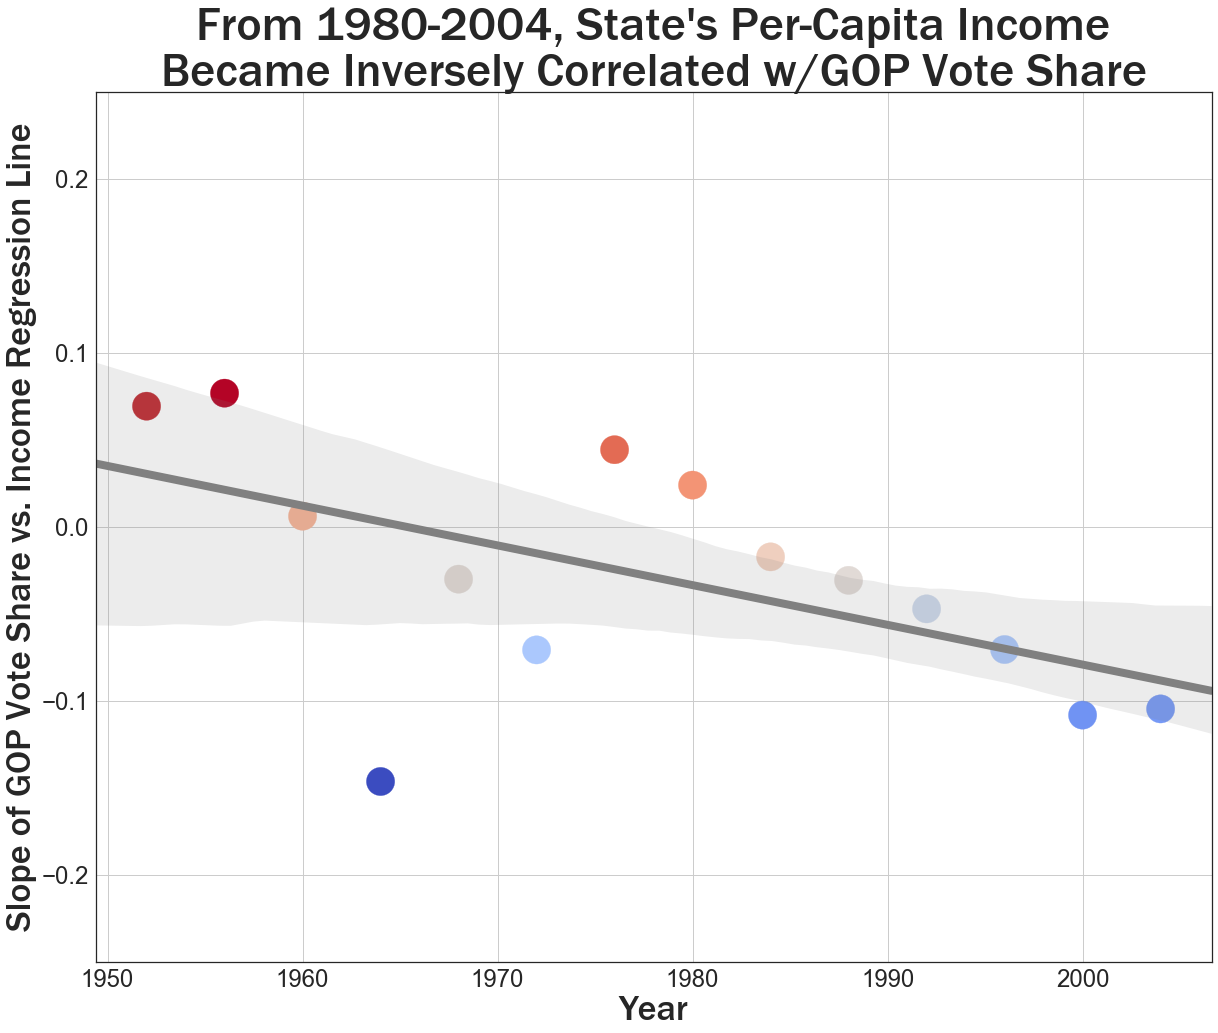

In [523]:
sns.set_style("white")
# cmap = sns.diverging_palette(250, 15, sep=1, s=90, l=60, n=20, center="dark", as_cmap=True)
fig, ax = plt.subplots(figsize=(20,16))
ax.set_ylim([-0.25,0.25])
points = plt.scatter(lr_df["Year"], lr_df["Coef"],
                     c=lr_df['Coef'], s=800, cmap="coolwarm")
sns.regplot('Year','Coef',data=lr_df, ax=ax, scatter=False, color='gray', line_kws={'lw':8})
ax.set_title('From 1980-2004, State\'s Per-Capita Income\nBecame Inversely Correlated w/GOP Vote Share',
             fontdict={'fontsize':48,'fontname':'Franklin Gothic Medium'})
ax.set_xlabel('Year', fontdict={'fontsize':36, 'fontname':'Franklin Gothic Medium'})
ax.set_ylabel('Slope of GOP Vote Share vs. Income Regression Line',
              fontdict={'fontsize':36, 'fontname':'Franklin Gothic Medium'})
ax.tick_params(axis='both', which='major', labelsize=24)
ax.grid()

Useful resources:
* [Color palettes](https://seaborn.pydata.org/tutorial/color_palettes.html)
* [Diverging palettes](https://seaborn.pydata.org/generated/seaborn.diverging_palette.html)
* [Regplots with color bars](https://stackoverflow.com/questions/30353363/seaborn-regplot-with-colorbar)

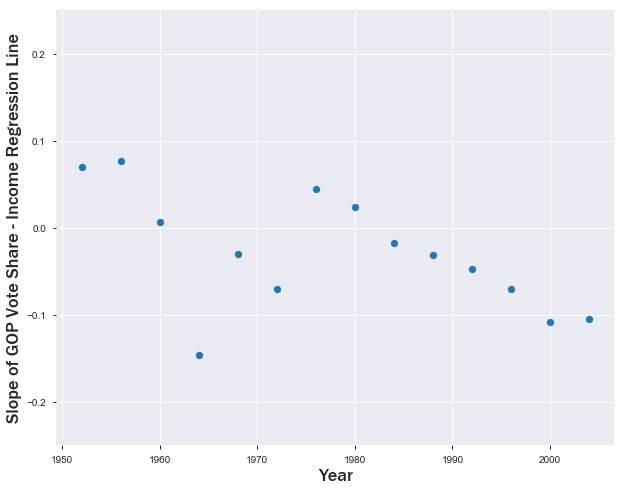

In [394]:
fig, ax = plt.subplots(figsize=(10,8))
ax.scatter(lr_df['Year'],lr_df['Coef'])
ax.set_ylim([-0.25,0.25])
ax.set_xlabel('Year', fontdict={'fontsize':'18', 'fontname':'Franklin Gothic Medium'})
ax.set_ylabel('Slope of GOP Vote Share - Income Regression Line',
              fontdict={'fontsize':'18', 'fontname':'Franklin Gothic Medium'})
plt.show()

Now, let's import the election results data for 2008 through 2016, along with income data, and we can replicate the above graph in a more current way:

### Importing 2008-2016 election data

In [154]:
with open('./2016-state.html','r') as f:
    pres_st_2016 = f.read()
f.close()
with open('./2012-state.html','r') as f:
    pres_st_2012 = f.read()
f.close()
with open('./2008-state.html','r') as f:
    pres_st_2008 = f.read()
f.close()

In [156]:
soup = BeautifulSoup(pres_st_2016, 'lxml')
header2016_html = soup.select_one('thead').select_one('tr').select('td')

In [157]:
header = [column.text for column in header2016_html]

In [159]:
# for i,j in enumerate(header):
#     print (i,j)

In [160]:
results2016_html = soup.select('tr')[3:54]

In [161]:
results = []
for row in results2016_html:
    results.append({header[i]:row.select('td')[i].text for i in [2,6,16,17]})

In [162]:
for row in results:
    row['Clinton'] = int(row['Clinton'].replace(',',''))
    row['Trump'] = int(row['Trump'].replace(',',''))
    row['Total\xa0Vote'] = int(row['Total\xa0Vote'].replace(',',''))

In [163]:
for row in results:
    row.update({'DemShare':(row['Clinton']/(row['Trump']+row['Clinton']))})
    row.update({'RepShare':(row['Trump']/(row['Trump']+row['Clinton']))})
    row.update({'Total':row['Total\xa0Vote']})

In [164]:
results_2016 = pd.DataFrame(results)
results_2016 = results_2016[['State','Total\xa0Vote','Clinton','Trump','DemShare','RepShare']]

In [165]:
results_2016.head()

,State,Total Vote,Clinton,Trump,DemShare,RepShare
0,Alabama,2123372,729547,1318255,0.356259,0.643741
1,Alaska,318608,116454,163387,0.416143,0.583857
2,Arizona,2604657,1161167,1252401,0.481100,0.518900
3,Arkansas,1130635,380494,684872,0.357149,0.642851
4,California,14237893,8753792,4483814,0.661282,0.338718


In [166]:
results_2016.rename({'Total\xa0Vote':'Total'},inplace=True)

In [167]:
soup = BeautifulSoup(pres_st_2012, 'lxml')
header2012_html = soup.select_one('thead').select_one('tr').select('td')

In [168]:
header = [column.text for column in header2012_html]

In [169]:
for i,j in enumerate(header):
    print (i,j)

0 Map
1 Pie
2 State
3 EV
4 EV
5 Total Vote
6 O
7 R
8 Margin
9 %Margin
10 Obama
11 Romney
12 Other
13 Obama
14 Romney
15 Other


In [175]:
results2012_html = soup.select('tr')[3:54]

In [176]:
results_2012 = []
for row in results2012_html:
    results_2012.append({header[i]:row.select('td')[i].text for i in [2,5,13,14]})

In [177]:
for row in results_2012:
    row['Obama'] = int(row['Obama'].replace(',',''))
    row['Romney'] = int(row['Romney'].replace(',',''))
    row['Total\xa0Vote'] = int(row['Total\xa0Vote'].replace(',',''))
for row in results_2012:
    row.update({'DemShare':(row['Obama']/(row['Romney']+row['Obama']))})
    row.update({'RepShare':(row['Romney']/(row['Romney']+row['Obama']))})
    row.update({'Total':row['Total\xa0Vote']})

In [178]:
results_2012 = pd.DataFrame(results_2012)
results_2012 = results_2012[['State','Total','Obama','Romney','DemShare','RepShare']]

In [179]:
results_2012.head()

,State,Total,Obama,Romney,DemShare,RepShare
0,Alabama,2074338,795696,1255925,0.387838,0.612162
1,Alaska,300495,122640,164676,0.426847,0.573153
2,Arizona,2306559,1025232,1233654,0.453866,0.546134
3,Arkansas,1069468,394409,647744,0.378456,0.621544
4,California,13055815,7854285,4839958,0.618728,0.381272


In [180]:
soup = BeautifulSoup(pres_st_2008, 'lxml')
header2008_html = soup.select_one('thead').select_one('tr').select('td')
header = [column.text for column in header2008_html]
for i,j in enumerate(header):
    print (i,j)

0 Map
1 Pie
2 State
3 EV
4 EV
5 Total Vote
6 O
7 M
8 Margin
9 %Margin
10 Obama
11 McCain
12 Other
13 Obama
14 McCain
15 Other


In [181]:
results2008_html = soup.select('tr')[3:54]
results_2008 = []
for row in results2008_html:
    results_2008.append({header[i]:row.select('td')[i].text for i in [2,5,13,14]})
for row in results_2008:
    row['Obama'] = int(row['Obama'].replace(',',''))
    row['McCain'] = int(row['McCain'].replace(',',''))
    row['Total\xa0Vote'] = int(row['Total\xa0Vote'].replace(',',''))
for row in results_2008:
    row.update({'DemShare':(row['Obama']/(row['McCain']+row['Obama']))})
    row.update({'RepShare':(row['McCain']/(row['McCain']+row['Obama']))})
    row.update({'Total':row['Total\xa0Vote']})
results_2008 = pd.DataFrame(results_2008)
results_2008 = results_2008[['State','Total','Obama','McCain','DemShare','RepShare']]

### Importing income data

One of the issues that is becoming increasingly clear to me is that it's unclear how to replicate the Gelman, et al.'s adjustments to their income data to account for a state's share of black residents. There was little, if any, explanation offered in the original research. It's very much possible, as a result, that we will have to default to using a non-adjusted income dataset for this study.

Another factor that has become increasingly important since Gelman, et al. published their work is a state's share of Hispanic/Latino voters. This voting block has become increasingly influential since the 2004 presidential election, especially in the wake of the failure of a comprehensive immigration-reform bill that Congress was considering during President George W. Bush's second term. As a result, it would be great to adjust the income data for states' Hispanic/Latino population shares.

However, for the time being we'll keep it simple. We can always perform these adjustments at a later time.

Let's go ahead and import some per-capita income data that was obtained from the Bureau of Economic Analysis, the same agency that provided the raw income data that Gelman, et al. used for their work.

In [312]:
percapinc = pd.read_csv(cap_path+'SA1-pres-years-percapinc.csv', skiprows=4, nrows=50)

In [313]:
percapinc['GeoFips'] = percapinc['GeoFips'].apply(lambda x: int(x/1000))

In [314]:
percapinc.drop('1948', axis=1, inplace=True)

In [315]:
percapinc.rename({'GeoFips':'statefips','GeoName':'state'}, axis=1, inplace=True)

In [316]:
percapinc['state'] = percapinc['state'].apply(lambda x: x.strip('*'))

In [317]:
percapinc_columns = list(percapinc.columns)

In [318]:
years = [int(column) for column in percapinc_columns[2:]]

In [319]:
percapinc_columns = percapinc_columns[0:2]

In [320]:
percapinc_columns.extend(years)

In [321]:
percapinc.columns = percapinc_columns

In [281]:
ep = EasyPeasy()

In [322]:
percapinc_infadj = percapinc.copy()
for year in years:
    if year < 1960:
        pass
    else:
        percapinc[str(year)+'_infadj'] = percapinc[year].apply(lambda x: ep.inflation_calculator(x, 'US', year, 1996))
        percapinc_infadj[year] = percapinc_infadj[year].apply(lambda x: ep.inflation_calculator(x, 'US', year, 1996))

In [323]:
percapinc_infadj.drop(labels=[1952,1956],axis=1,inplace=True)

In [324]:
st_nonadjAA = st
st1960_nonadjAA = st[st['year'] == 1960]
st1964_nonadjAA = st[st['year'] == 1964]
st1968_nonadjAA = st[st['year'] == 1968]
st1972_nonadjAA = st[st['year'] == 1972]
st1976_nonadjAA = st[st['year'] == 1976]
st1980_nonadjAA = st[st['year'] == 1980]
st1984_nonadjAA = st[st['year'] == 1984]
st1988_nonadjAA = st[st['year'] == 1988]
st1992_nonadjAA = st[st['year'] == 1992]
st1996_nonadjAA = st[st['year'] == 1996]
st2000_nonadjAA = st[st['year'] == 2000]
st2004_nonadjAA = st[st['year'] == 2004]

In [325]:
st1960_nonadjAA.head()

,state,year,stateabb,statefips,total,dem,rep,st.income,state.1,year.1,st.pop,inc.pop,st.repshare,z.st.inc,z.st.pop,z.st.inc.pop
3,Alabama,1960,AL,1,564,318,238,5099621,Alabama,1960,3274000.0,1.557612,0.428058,-0.149718,-0.041014,-0.687769
17,Alaska,1960,AK,2,61,30,31,665628,Alaska,1960,229000.0,2.906672,0.508197,-0.367517,-0.443700,0.918870
31,Arizona,1960,AZ,4,398,177,221,2719385,Arizona,1960,1321000.0,2.058581,0.555276,-0.266636,-0.299289,-0.091149
45,Arkansas,1960,AR,5,429,215,185,2514153,Arkansas,1960,1789000.0,1.405340,0.462500,-0.276717,-0.237398,-0.869115
59,California,1960,CA,6,6507,3224,3260,44793889,California,1960,15870000.0,2.822551,0.502776,1.800076,1.624743,0.818687


In [332]:
pd.DataFrame([st1960_nonadjAA['state'],stats.zscore(st1960_nonadjAA['st.income'])])

,3,17,31,45,59,73,87,101,115,129,...,563,577,591,605,619,633,647,661,675,689
state,Alabama,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,Florida,Georgia,...,South Dakota,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming
Unnamed 0,-0.559052,-0.261732,3.84934,-0.0427444,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [333]:
percapinc_USA = pd.read_csv(cap_path+'SA1-pres-years-percapinc-natl.csv', skiprows=4, nrows=1)

In [337]:
percapinc_USA = percapinc_USA.transpose()

In [338]:
percapinc_USA = percapinc_USA.drop(labels=['GeoName','GeoFips'], axis=0)

In [340]:
percapinc_USA.columns = ['percapinc']

In [342]:
percapinc_USA.index = percapinc_USA.index.astype('int64')

In [356]:
percapinc_USA.loc[1948]['percapinc_infadj1996']

0

In [362]:
percapinc_USA_infadj = []
for i in range(len(percapinc_USA.index)):
    percapinc_USA_infadj.append(ep.inflation_calculator(percapinc_USA['percapinc'].values[i],'US',percapinc_USA.index[i],1996))

/Users/kolliparap/anaconda3/lib/python3.6/site-packages/easymoney/money.py:213: UserWarning: 
Inflation (CPI) data for 1948 in 'United States' could not be obtained from the
International Monetary Fund database currently cached.
Falling back to 1960.
  warn(warn_msg % (year, natural_region_name, str(fall_back_year)))
/Users/kolliparap/anaconda3/lib/python3.6/site-packages/easymoney/money.py:213: UserWarning: 
Inflation (CPI) data for 1952 in 'United States' could not be obtained from the
International Monetary Fund database currently cached.
Falling back to 1960.
  warn(warn_msg % (year, natural_region_name, str(fall_back_year)))
/Users/kolliparap/anaconda3/lib/python3.6/site-packages/easymoney/money.py:213: UserWarning: 
Inflation (CPI) data for 1956 in 'United States' could not be obtained from the
International Monetary Fund database currently cached.
Falling back to 1960.
  warn(warn_msg % (year, natural_region_name, str(fall_back_year)))


In [366]:
percapinc_USA['percapinc_infadj1996'] = percapinc_USA_infadj

In [367]:
percapinc_USA

,percapinc,percapinc_infadj1996
1948,1449,7679.57
1952,1794,9508.03
1956,2062,10928.41
1960,2323,12311.69
1964,2736,13836.69
1968,3616,16305.24
1972,4853,18201.47
1976,6856,18893.86
1980,10153,19326.43
1984,13860,20923.40


In [370]:
percapinc_USA.loc[1960]['percapinc_infadj1996']

12311.69

In [518]:
stats.zscore(income[income['LineCode'] == 3]['1960'][1:52])

array([-1.3663418 ,  2.84474329, -0.16317463, -1.72162486,  1.52605463,
        0.46238511,  1.38655699,  1.48464127,  1.94018826, -0.27433682,
       -1.01105874,  0.67817053, -0.61218267,  1.07050765,  0.01555672,
       -0.30049262, -0.02149734, -1.23120346, -1.09606512, -0.51191874,
        0.5822659 ,  0.73484144,  0.40353454, -0.10650371, -2.06600966,
        0.01773637, -0.19586939, -0.00623978,  1.77889411,  0.1005631 ,
        1.0857652 , -0.48576293,  1.4127128 , -1.1941494 , -0.67321289,
        0.42533105, -0.52935594,  0.2596776 ,  0.21608458,  0.29891131,
       -1.56904931, -0.61436232, -1.2072273 , -0.43563097, -0.23728276,
       -0.57948791, -0.35280424,  0.64983507, -1.20504765,  0.08748519,
        0.30545026])

In [507]:
income = pd.read_csv(cap_path+'SA1-pres-years-all-natl.csv', skiprows=4, nrows=180)

In [509]:
income.columns

Index(['GeoFips', 'GeoName', 'LineCode', 'Description', '1948', '1952', '1956',
       '1960', '1964', '1968', '1972', '1976', '1980', '1984', '1988', '1992',
       '1996', '2000', '2004', '2008', '2012', '2016'],
      dtype='object')